### MasaCtrl: Tuning-free Mutual Self-Attention Control for Consistent Image Synthesis and Editing

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
import numpy as np

from tqdm import tqdm
from einops import rearrange, repeat
from omegaconf import OmegaConf

from diffusers import DDIMScheduler, StableDiffusionPipeline
from diffusers.utils.torch_utils import randn_tensor
from masactrl.diffuser_utils import MasaCtrlPipeline
from masactrl.masactrl_utils import AttentionBase
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
import cv2
from torchvision.utils import save_image
from torchvision.io import read_image
from pytorch_lightning import seed_everything
from matplotlib import pyplot as plt
torch.cuda.set_device(0)  # set the GPU device

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-16 13:10:21.527459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 13:10:22.921807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Model Construction

In [2]:
# Note that you may add your Hugging Face token to get access to the models
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model_path = "xyn-ai/anything-v4.0"
model_path = "/hy-tmp/SD2-1-base"
# model_path = "runwayml/stable-diffusion-v1-5"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    custom_pipeline="/hy-tmp/MyREMOVAL/pipeline_mine_refine.py",
    torch_dtype=torch.float16
)
pipe = pipe.to(device)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]
/root/.cache/huggingface/modules/diffusers_modules/local/pipeline_mine_refine.py:203: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would

In [37]:
from masactrl.masactrl import MutualSelfAttentionControl,MutualSelfAttentionControlMask_An,MutualSelfAttentionControlMask_An_aug,MutualSelfAttentionControlMask_An_xrep
from torchvision.io import read_image
from torchvision.transforms.functional import gaussian_blur

def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(torch.float16).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (512, 512))
    mask = gaussian_blur(mask, kernel_size=(13, 13))
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask.to(torch.float16).to(device)
    return mask

seed = 123
seed_everything(seed)
generator=torch.Generator("cuda").manual_seed(seed)
sample = "alex"
out_dir = f"./workdir/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
#out_dir = os.path.join(out_dir, "40")
os.makedirs(out_dir, exist_ok=True)
# source image
SOURCE_IMAGE_PATH = f"/hy-tmp/MyREMOVAL/examples/img/{sample}.png"
MASK_PATH = f"/hy-tmp/MyREMOVAL/examples/mask/{sample}_mask.png"
#SOURCE_IMAGE_PATH = "/home/user01/AnonymousEditing/examples/img/an.png"
#MASK_PATH = "/home/user01/AnonymousEditing/examples/mask/an_mask.png"
#source_image = load_image("/hy-tmp/DATA/test_sampled/37a5866685fce611_m02p5f1q_5fc106cc.jpg", device)
#mask = load_mask("/hy-tmp/new_outputs/37a5866685fce611_m02p5f1q_5fc106cc_mask.png", device)
source_image = load_image(SOURCE_IMAGE_PATH, device)
mask = load_mask(MASK_PATH, device)


Global seed set to 123


In [38]:
""" source_prompt = ""
target_prompt = ""
prompts = [source_prompt, target_prompt]
with torch.no_grad():
    # invert the source image
    start_code, x0 = pipe.invert_sde(
                                source_image,
                                source_prompt,
                                strength=0.8,
                                generator=generator,
                                num_inference_steps=50) """

' source_prompt = ""\ntarget_prompt = ""\nprompts = [source_prompt, target_prompt]\nwith torch.no_grad():\n    # invert the source image\n    start_code, x0 = pipe.invert_sde(\n                                source_image,\n                                source_prompt,\n                                strength=0.8,\n                                generator=generator,\n                                num_inference_steps=50) '

In [39]:
source_prompt = ""
target_prompt = ""
prompts = [source_prompt, target_prompt]
with torch.no_grad():
    # invert the source image
    start_code, x0 = pipe.invert(
    #start_code, latents_list = pipe.invert(
                                source_image,
                                mask,
                                source_prompt,
                                generator,
                                guidance_scale=1,
                                num_inference_steps=50,
                                return_intermediates=False)

In [40]:
"""  # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(pred_x0_list[30:40][i])
    ax.axis('off')  # 隐藏坐标轴

plt.show()  """

"  # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)\nfig, axs = plt.subplots(2, 5, figsize=(15, 6))\n\nfor i, ax in enumerate(axs.flatten()):\n    ax.imshow(pred_x0_list[30:40][i])\n    ax.axis('off')  # 隐藏坐标轴\n\nplt.show()  "

In [41]:
latent_input = start_code
test_mask = F.max_pool2d(mask, (8, 8)).round()
start_code = start_code.expand(len(prompts), -1, -1, -1)

In [42]:
# inference the synthesized image with MasaCtrl
START_STEP = 0
END_STEP = 50
LAYER = 7 #0~5down,6mid,7~15up
END_LAYER = 16

# hijack the attention module
editor = MutualSelfAttentionControlMask_An_aug(START_STEP, END_STEP, LAYER, END_LAYER, mask=mask)
regiter_attention_editor_diffusers(pipe, editor)

#image, pred_x0_list_denoise, latents_list_denoise = pipe(
image = pipe(
    prompts,
    width=512,
    height=512,
    num_inference_steps=50,
    guidance_scale=1.0,
    latents=start_code,
    x0_latents=x0,
    generator=generator,
    #x0_latents=latents_list[0],
    #record_list = list(reversed(latents_list)),
    mask = mask,
    return_intermediates = False,
)

Syntheiszed images are saved in ./workdir/alex/sample_0


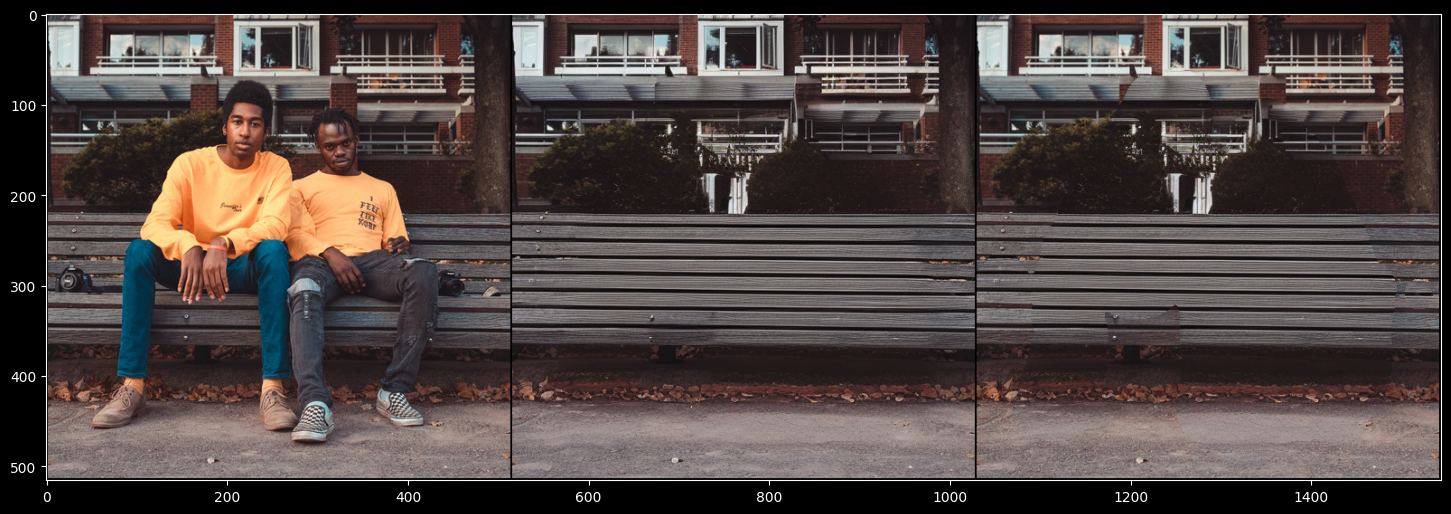

In [43]:
out_tile = mask * image[-1:] + (1 - mask) * (source_image* 0.5 + 0.5)
out_image = torch.concat([source_image* 0.5 + 0.5,
                         image[-1:],
                         out_tile],
                         #image[:1]],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"anonymous_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"anonymous_tile_step{END_STEP}_layer{LAYER}.png"))
#save_image(out_image[2], os.path.join(out_dir, f"compare_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 24))
plt.imshow(img_ori)

In [44]:
""" out_image = torch.cat([source_image * 0.5 + 0.5,
                       image[0:1],
                       image[-1:]], dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"reconstructed_source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))

print("Syntheiszed images are saved in", out_dir)

img_ori = cv2.imread(os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_ori) """



' out_image = torch.cat([source_image * 0.5 + 0.5,\n                       image[0:1],\n                       image[-1:]], dim=0)\nsave_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[1], os.path.join(out_dir, f"reconstructed_source_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[2], os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))\n\nprint("Syntheiszed images are saved in", out_dir)\n\nimg_ori = cv2.imread(os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))\nimg_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)\nplt.figure(figsize=(6, 6))\nplt.imshow(img_ori) '

In [45]:
""" out_dir = f"/hy-tmp/MyREMOVAL/visualization/{sample}_notend/pred_x0_steps"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for i in range(len(pred_x0_list_denoise)):
    save_image(pred_x0_list_denoise[i], os.path.join(out_dir, f"pred_x0_step{i+1}.png")) """

' out_dir = f"/hy-tmp/MyREMOVAL/visualization/{sample}_notend/pred_x0_steps"\nif not os.path.exists(out_dir):\n    os.makedirs(out_dir)\nfor i in range(len(pred_x0_list_denoise)):\n    save_image(pred_x0_list_denoise[i], os.path.join(out_dir, f"pred_x0_step{i+1}.png")) '

In [46]:
""" out_dir = f"/hy-tmp/MyREMOVAL/visualization/{sample}_notend/latents_steps"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for i in range(len(latents_list_denoise)):
    save_image(latents_list_denoise[i], os.path.join(out_dir, f"latents_step{i+1}.png")) """

' out_dir = f"/hy-tmp/MyREMOVAL/visualization/{sample}_notend/latents_steps"\nif not os.path.exists(out_dir):\n    os.makedirs(out_dir)\nfor i in range(len(latents_list_denoise)):\n    save_image(latents_list_denoise[i], os.path.join(out_dir, f"latents_step{i+1}.png")) '

In [47]:
""" # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(pred_x0_list_denoise[:10][i])
    ax.axis('off')  # 隐藏坐标轴

plt.show() """

" # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)\nfig, axs = plt.subplots(2, 5, figsize=(15, 6))\n\nfor i, ax in enumerate(axs.flatten()):\n    ax.imshow(pred_x0_list_denoise[:10][i])\n    ax.axis('off')  # 隐藏坐标轴\n\nplt.show() "